<h1> ______________________________________ </h1>

<h1> Time and Energy resolution calculation </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we calculate the energy and time resolution of our photosensor (SiPM Hamamatsu in this case) the following way:</p>

- <p style="font-size: 17px; color: black; font-weight: bold;"> Time resolution: </p> 
<p style="font-size: 17px; color: black;"> We set a voltage threshold and we measure the time difference between when our signal and our trigger waveform pass that threshold. The std of that time difference distribution will be our time resolution. The time resolution is not the same for all signals so we differentiate among signals of 1pe, 2pe, 3pe, etc. </p> 


- <p style="font-size: 17px; color: black; font-weight: bold;"> Energy resolution: </p> 
<p style="font-size: 17px; color: black;"> We save for each waveform the value of the peak, then we do the distribution of that value for each waveform type, ie we do different distributions separating waveforms corresponding to 1pe, 2pe, 3pe, etc. The std of that peak distribution will be our energy resolution. </p> 


<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> Took MORE data with the new scope (10K events). </p>
-  <p style="font-size: 17px; color: black;"> Waveforms include just 1 peak. </p>
-  <p style="font-size: 17px; color: black;"> Signal happens AFTER THE TRIGGER. </p>


-  <p style="font-size: 17px; color: black;"> Use interpolation to get the EXACT time at which the waveform cuts the threshold. This way we can basically work with a function intead of the data. </p>


-  <p style="font-size: 17px; color: black;"> Calculate chi2 with a built in function instead of manually. </p>
-  <p style="font-size: 17px; color: black;"> Variable bining in the distributions as sqrt(Nevents). </p>


-  <p style="font-size: 17px; color: black;"> Instead of obtaining the Npe peaks ad hoc we do it finding the peaks in the maximums distribution. </p>
-  <p style="font-size: 17px; color: black;"> Same way use this distribution to determine dV from each peak to get rid of the in between events. </p>


-  <p style="font-size: 17px; color: black;"> We can choose between a variable or a fixed threshold with fix_th = True/False. </p>


-  <p style="font-size: 17px; color: black;"> Energy distribution in % instead of absolute values. </p>
-  <p style="font-size: 17px; color: black;"> Fit the sigma vs Npe plot to the corresponding cuadratic sum of terms. </p>



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import scipy
from scipy import stats, integrate
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import root, root_scalar

import os

# Data

In [2]:
filename = []

path = '/home/investigator/mariandbt/python/data/'
path = path + '20230504/'


In [3]:
data = []

# Get all files in the folder
files = os.listdir(path)
# max_files_used = int(len(files)/2)
max_files_used = int(len(files))

print('We are using %s files out of %s'%(max_files_used, len(files)))

# Loop through each file 
for file_name in files[:max_files_used]:
    file = os.path.join(path, file_name)
    with open(file,'r', encoding='ascii') as fp:
        for i, line in enumerate(fp):
            if i > 15:
                data.append(np.asarray(line.split(','), dtype=float))
                
                
fp.close()

print('DONE READING!')

We are using 10000 files out of 10000
DONE READING!


In [4]:
len(files)
max_files_used

10000

In [5]:
waveform = np.array(data)

# n_frames = int(len(files))
n_frames = int(max_files_used)
n_points = int(len(waveform)/n_frames)

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  1250
n_frames =  10000


# Functions

In [47]:
# Gaussian
# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
# def gauss(x,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian 
#     return (x.sum()/gaussian.sum())*gaussian 

# Function offsetting
# To find the cut of a function with a certain value first we offset the function then find the roots
def f_cut(x, f, val):
    return f(x) - val

# Resolution equation
def resolution_eq(E, a, b, c):
    
    res = np.sqrt( (a/np.sqrt(E))**2 + (b/E)**2 + c**2)
    
    return res

# Global parameters

<p style="font-size: 17px; color: black;"> Time, LED and signal variables we'll be using ALL along

In [7]:
time = waveform[:, 0]*1e6 # [us]
LED = waveform[:, 2]*1e3 # [mV]
signal = waveform[:, 1]*1e3 # [mV]

# Offsets
offset_LED = LED[LED < 0].mean(); LED = LED - offset_LED

offset_signal = signal[signal < 0].mean(); signal = signal - offset_signal

In [8]:
dV = 50 # [mV] Voltage difference from the multi-pe peaks we're considering

In [9]:
fix_th = False # if we want to use a fixed threshold (determined after the multi-pe peaks)

# Analysis

<p style="font-size: 17px; color: black;"> Determination of the N pe peaks USING PEAK DISTRIBUTION

<p style="font-size: 15px; color: black;"> Save the maximum of each waveform to do the distribution later

In [10]:
pe_peaks = []

for frame in range(n_frames):
    
    ss = signal[frame*n_points: (frame + 1)*n_points].copy() # [mV]
    pe_peaks.append(ss.max())
    
pe_peaks = np.array(pe_peaks)
    

<p style="font-size: 15px; color: black;"> Set the parameters to later find the peaks in the distribution and determine the acceptance region around this peak 

In [11]:
height_min = n_frames/250. # height threshold to which consider a peak
height_min = 20. # height threshold to which consider a peak
dist_min = 10. # min distance between peaks required
dif_min = None # min height difference between the peak point and their neighbours 

<p style="font-size: 15px; color: black;"> Waveform's maximums distribution and location of the photo-electrons peaks and the acceptance region around 

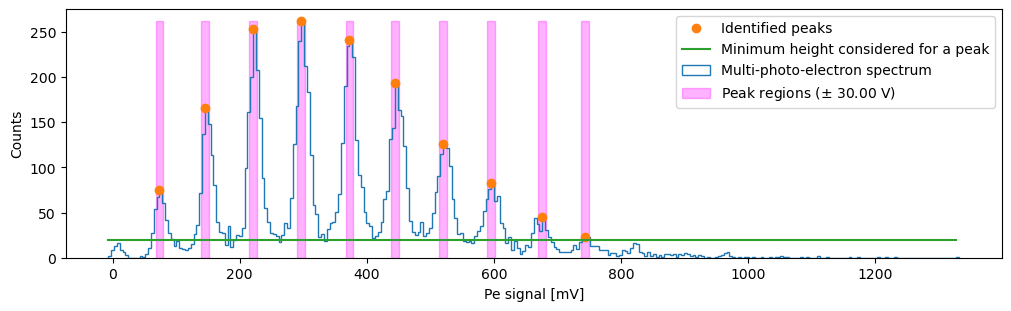

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3), constrained_layout=True)
events, bins, bars = ax.hist(pe_peaks, 300, 
                             density=False, 
                             label='Multi-photo-electron spectrum', 
                             histtype='step')
x_ax = bins[:-1]
diffs = np.abs(np.diff(bins))
accept_region = np.array(dV/diffs, dtype = int)

peaks, _ = find_peaks(events, height=height_min, threshold=dif_min, distance=dist_min)

for ii in range(len(peaks)):
    ax.fill_between([(x_ax[peaks] - accept_region[peaks])[ii], 
                     (x_ax[peaks] + accept_region[peaks])[ii]], 
                    events[peaks].max(), 
                    color = 'magenta', alpha = 0.3, label = r'Peak regions ($\pm$ %.2f mV)'%(dV)) 

ax.plot(x_ax[peaks], events[peaks], 'o', label = 'Identified peaks')
ax.plot(x_ax, height_min*np.ones(len(x_ax)), label = 'Minimum height considered for a peak')

ax.set_xlabel('Pe signal [mV]')
ax.set_ylabel('Counts')

hand, labl = ax.get_legend_handles_labels()
hand, labl = np.array(hand), np.array(labl)
not_duplicated = ~pd.DataFrame(labl).duplicated()

ax.legend(hand[not_duplicated], labl[not_duplicated], loc = 'best')
# ax.legend(loc='best')

In [13]:
signal_pe = x_ax[peaks]
n_pe = len(signal_pe)
print('Npe = ', n_pe)

Npe =  10


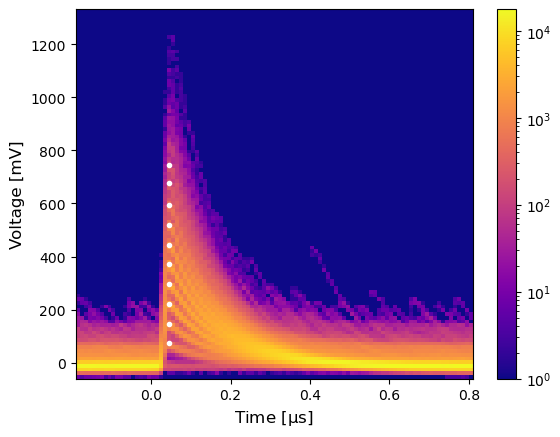

In [14]:
import matplotlib as mpl
import copy

fig, ax = plt.subplots(1,1)

my_cmap = copy.copy(plt.get_cmap('plasma')) # copy the default cmap
my_cmap.set_bad(my_cmap.colors[0]) #  set the color of invalid or masked values in the colormap


counts, xedges, yedges, im = ax.hist2d(time[:3000*n_points], signal[:3000*n_points], 
                                       bins=100, rasterized=True, 
                                       range=((time.min(),time.max()), (signal.min(), signal.max())), 
                                       cmap=my_cmap, norm=mpl.colors.LogNorm(vmin = 1))

for ii in range(n_pe):
    ax.plot(0.045, signal_pe[ii], 'ow', markersize = 3, label = '%s pe'%(ii))
    


ax.set_xlabel(r"Time [$\mathrm{\mu}$s]", size='larger')
ax.set_ylabel("Voltage [mV]", size='larger')

# ax.legend(loc = 'best')

fig.colorbar(im, ax = ax, orientation='vertical')
# fig.savefig("waveforms.pdf")

<p style="font-size: 17px; color: black;"> Set fixed threshold to 50% of the single photo-electron

In [15]:
th_fixed = .5*signal_pe[0] # [mV] Height at which we measure the time difference between LED and Signal

<p style="font-size: 17px; color: black; font-weight: bold"> Waveform

<p style="font-size: 17px; color: black;"> Interpolate the waveform to create a function

In [86]:
frame = 23
frame = 789
# frame = 1755; th = 57.38 # [mV]
# frame = 2031; th = 131.43 # [mV]
# frame = 266; th = 114.13 # [mV]
# frame = 1712
# frame = 5484

In [87]:
tt = time[frame*n_points: (frame + 1)*n_points].copy()  # [us]
ss = signal[frame*n_points: (frame + 1)*n_points].copy() # [mV]
ll = LED[frame*n_points: (frame + 1)*n_points].copy() # [mV]

<p style="font-size: 17px; color: black;"> Time region where to look for signal

In [88]:
tt_min = 0. # [us]
tt_max = 0.2 # [us]

tt_region_mask = (tt > tt_min) & (tt < tt_max) # Where to look for the signal

<p style="font-size: 17px; color: black;"> Threshold to consider a peak in this waveform

In [89]:
th = max(0.8*signal_pe[0], min(0.8*ss[tt_region_mask].max(), 0.8*ll.max()))

if fix_th:
    th = th_fixed
            
print('threshold = %.2f mV'%(th))

threshold = 233.37 mV


<p style="font-size: 17px; color: black;"> Data waveform

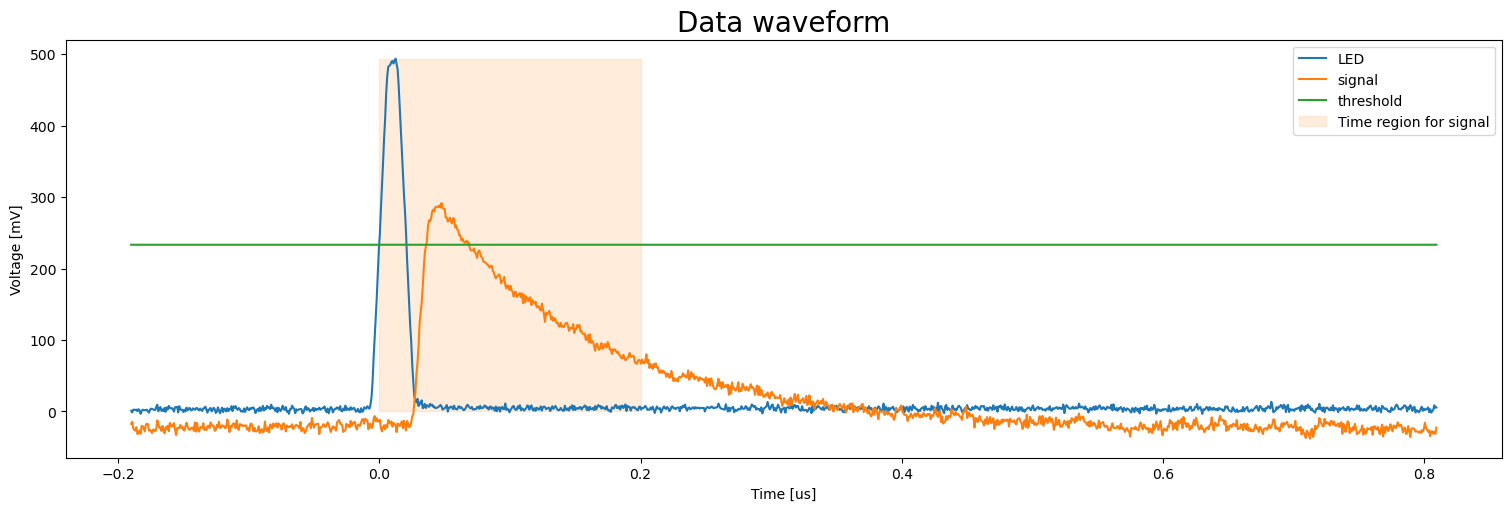

In [90]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

ax.plot(tt, ll, label = 'LED')
ax.plot(tt, ss, label = 'signal')
ax.plot(tt, th*np.ones(len(tt)), label = 'threshold')

ax.fill_between([tt_min, tt_max], max(ll.max(), ss.max()), 
                color = 'peachpuff', alpha = 0.5, label = r'Time region for signal') 

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [us]');
ax.set_title('Data waveform', size = 20);
ax.legend(loc = 'best')

<p style="font-size: 17px; color: black;"> Waveform interpolation and finding the cut with the threshold

In [91]:
# Define the interpolation functions
f_ss = interp1d(tt, ss)
f_ll = interp1d(tt, ll)

# Define the intervals where to search for roots
t0 = tt[ss - th < 0.][0]
tf_ss = tt[ss - th > 0.][0]
tf_ll = tt[ll - th > 0.][0]

# Find the roots of the new function for val = th
root_ss = root_scalar(f_cut, args=(f_ss, th,), bracket=[t0, tf_ss]).root
root_ll = root_scalar(f_cut, args=(f_ll, th,), bracket=[t0, tf_ll]).root

dt = np.fabs(root_ss - root_ll)
print('dt = %.2f us'%(dt))


dt = 0.04 us


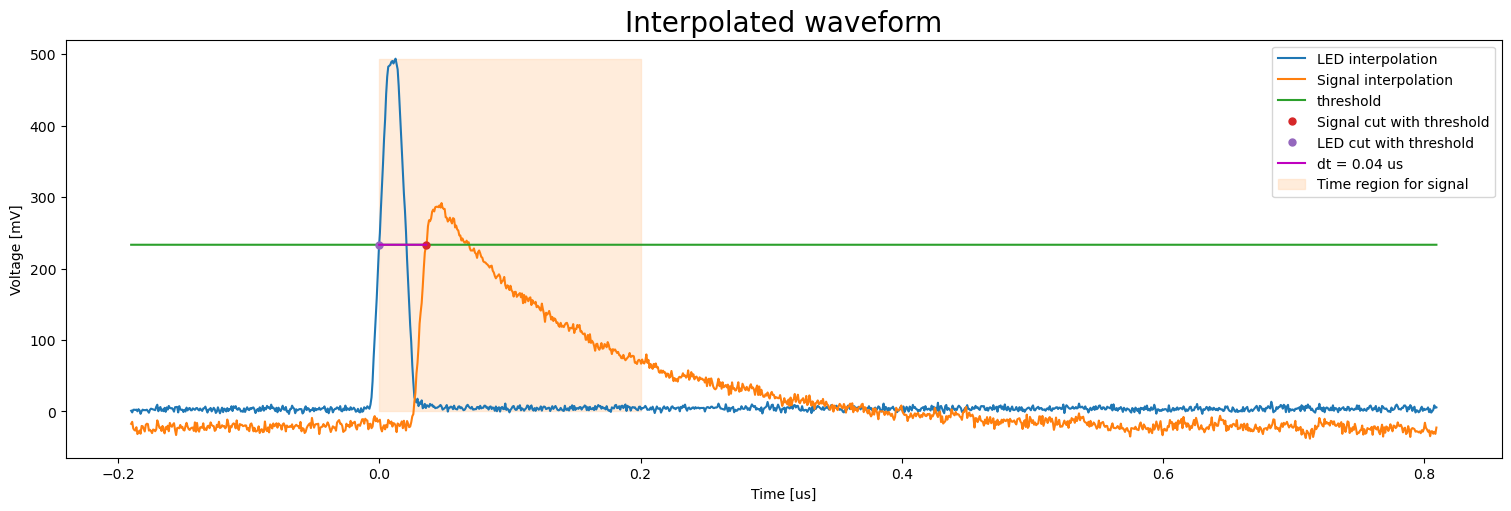

In [92]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5), constrained_layout=True)

ax.plot(tt, f_ll(tt), label = 'LED interpolation')
ax.plot(tt, f_ss(tt), label = 'Signal interpolation')
ax.plot(tt, th*np.ones(len(tt)), label = 'threshold')

ax.fill_between([tt_min, tt_max], max(ll.max(), ss.max()), 
                color = 'peachpuff', alpha = 0.5, label = r'Time region for signal') 

ax.plot(root_ss, th, 'o', markersize = 5, label = 'Signal cut with threshold')
ax.plot(root_ll, th, 'o', markersize = 5, label = 'LED cut with threshold')
ax.plot(np.linspace(root_ss, root_ll, len(tt)), th*np.ones(len(tt)), '-m', label = 'dt = %.2f us'%(dt))

ax.set_ylabel('Voltage [mV]');
ax.set_xlabel('Time [us]');
ax.set_title('Interpolated waveform', size = 20);
ax.legend(loc = 'best')

<p style="font-size: 17px; color: black;"> Difference in time calculation for all frames

<p style="font-size: 15px; color: black;"> Note how we're working with the fact that the signal appears in a certain time region to constrain the valid region of signal we use using the mask

In [95]:
dt = []
s_peak = []

try:
    for frame in range(n_frames):

        tt = time[frame*n_points: (frame + 1)*n_points].copy()  # [us]
        ss = signal[frame*n_points: (frame + 1)*n_points].copy() # [mV]
        ll = LED[frame*n_points: (frame + 1)*n_points].copy() # [mV]
        
        tt_region_mask = (tt > tt_min) & (tt < tt_max) # Where to look for the signal

        th = max(0.8*signal_pe[0], min(0.8*ss[tt_region_mask].max(), 0.8*ll.max()))
        
        if fix_th:
            th = th_fixed
        
        if ss[tt_region_mask].max() < th: 
            print('NO SIGNAL HERE! frame = %s; th = %.2f # [mV]'%(frame, th))
            continue
            
        if ss[tt_region_mask][0] > th: 
            print('This is not signal, it is the tail of a noise pulse! frame = %s; th = %.2f # [mV]'%(frame, th))
            continue

        # Define the interpolation functions
        f_ss = interp1d(tt, ss) 
        f_ll = interp1d(tt, ll)
        
        # Define the intervals where to search for roots
        t0 = tt[ss - th < 0.][0]
        tf_ss = tt[ss - th > 0.][0]
        tf_ll = tt[ll - th > 0.][0]

        # Find the roots of the new function for val = th
        root_ss = root_scalar(f_cut, args=(f_ss, th,), bracket=[t0, tf_ss]).root
        root_ll = root_scalar(f_cut, args=(f_ll, th,), bracket=[t0, tf_ll]).root

        s_peak.append(ss.max())
        dt.append(np.fabs(root_ss - root_ll))
    
except Exception as e:
    print("Python sais:", str(e))
    print("Marian sais: Error accured in frame ", frame)
    
dt = np.array(dt)
s_peak = np.array(s_peak)
    

NO SIGNAL HERE! frame = 147; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 159; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 176; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 260; th = 58.85 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 266; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 478; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 490; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 533; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 722; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 758; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 848; th = 58.85 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 973; th = 186.37 # [mV]
NO SIGNAL HERE! frame = 976; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 1027; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 1148; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 1238; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 1289; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 1432; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 1446; th = 58.85 # [mV]
NO SIGNAL HERE! frame = 15

<p style="font-size: 17px; color: black;"> Peak identification

In [96]:
mask_pe = []
for i in range(n_pe):
    mask_pe.append(np.fabs(s_peak - signal_pe[i]) <= dV) # for fixed dV


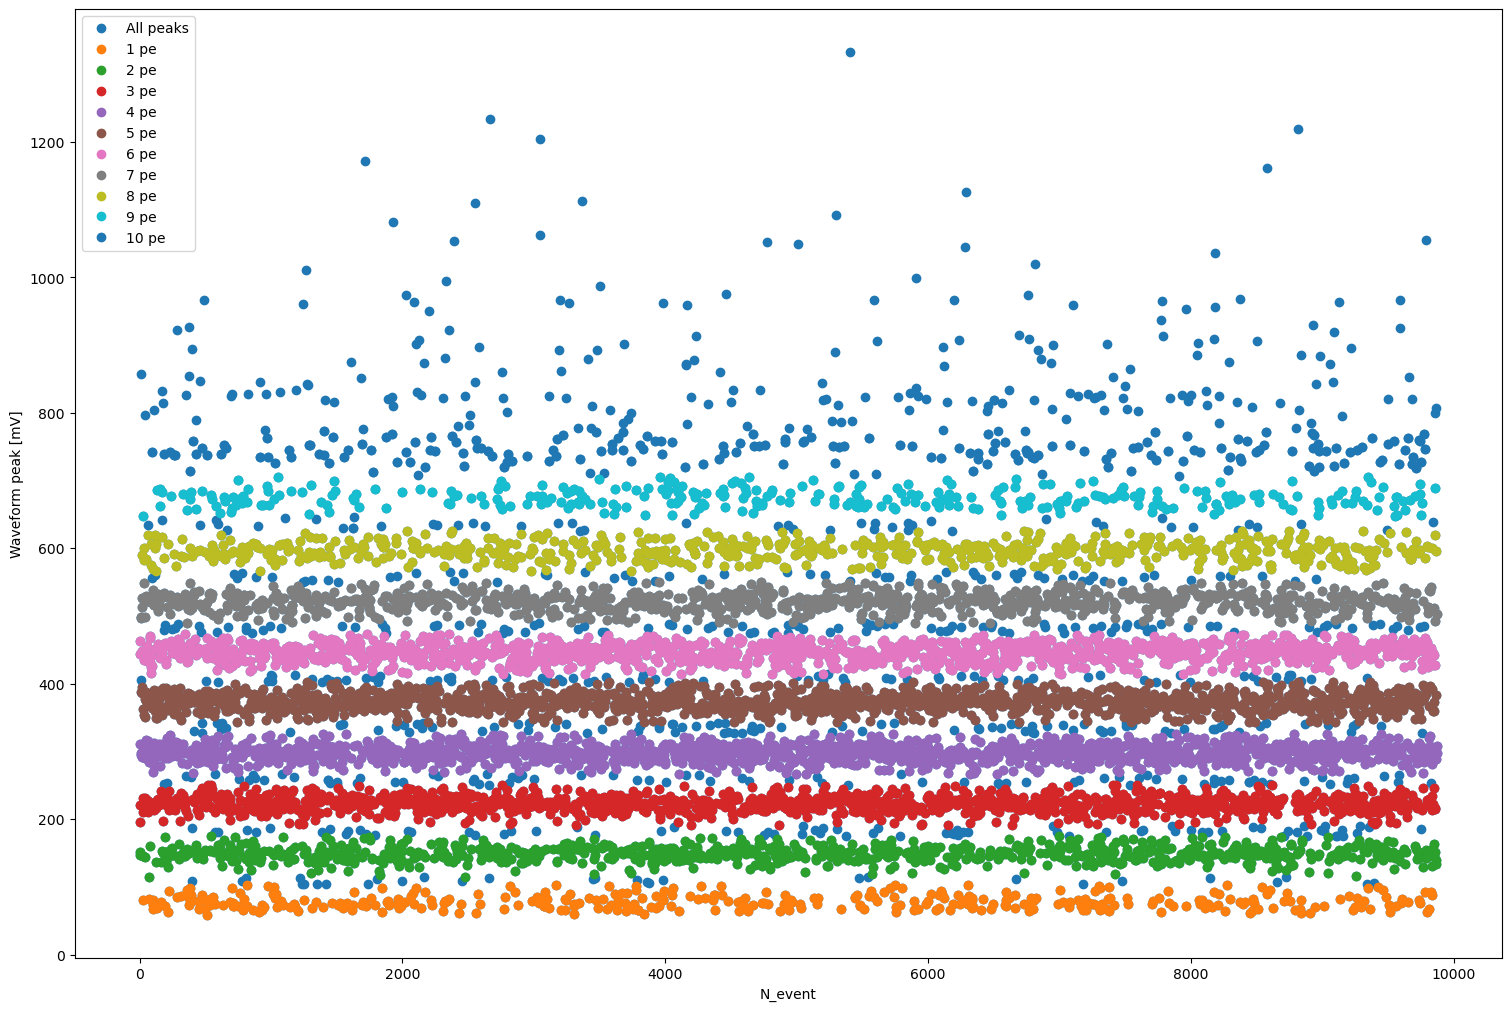

In [97]:
fig, ax = plt.subplots(1, 1, figsize = (15, 10), constrained_layout=True)

#______________________plot settings________________________________________________________

x_ax = np.arange(len(s_peak))

ax.plot(x_ax, s_peak, 'o', label = 'All peaks')

for ii in range(len(mask_pe)):
    ax.plot(x_ax[mask_pe[ii]], s_peak[mask_pe[ii]], 'o', label = '%s pe'%(ii + 1))

ax.set_ylabel('Waveform peak [mV]');
ax.set_xlabel('N_event');

# ax.set_xlim([0, 20])
# ax.set_ylim([s_peak.min(), 150])
ax.legend(loc = 'best')


<p style="font-size: 17px; color: black;"> Time resolution calculation

In [26]:
from scipy.stats import chisquare

observed = np.array([10, 20, 30])
expected = np.array([15, 15, 30])

chi2, p_value = chisquare(observed, expected)

print('chi^2 =', chi2)
print('p-value =', p_value)


chi^2 = 3.3333333333333335
p-value = 0.1888756028375618


In [27]:
len(events), len(bins[:-1]), len(x_ax)

(300, 300, 9873)

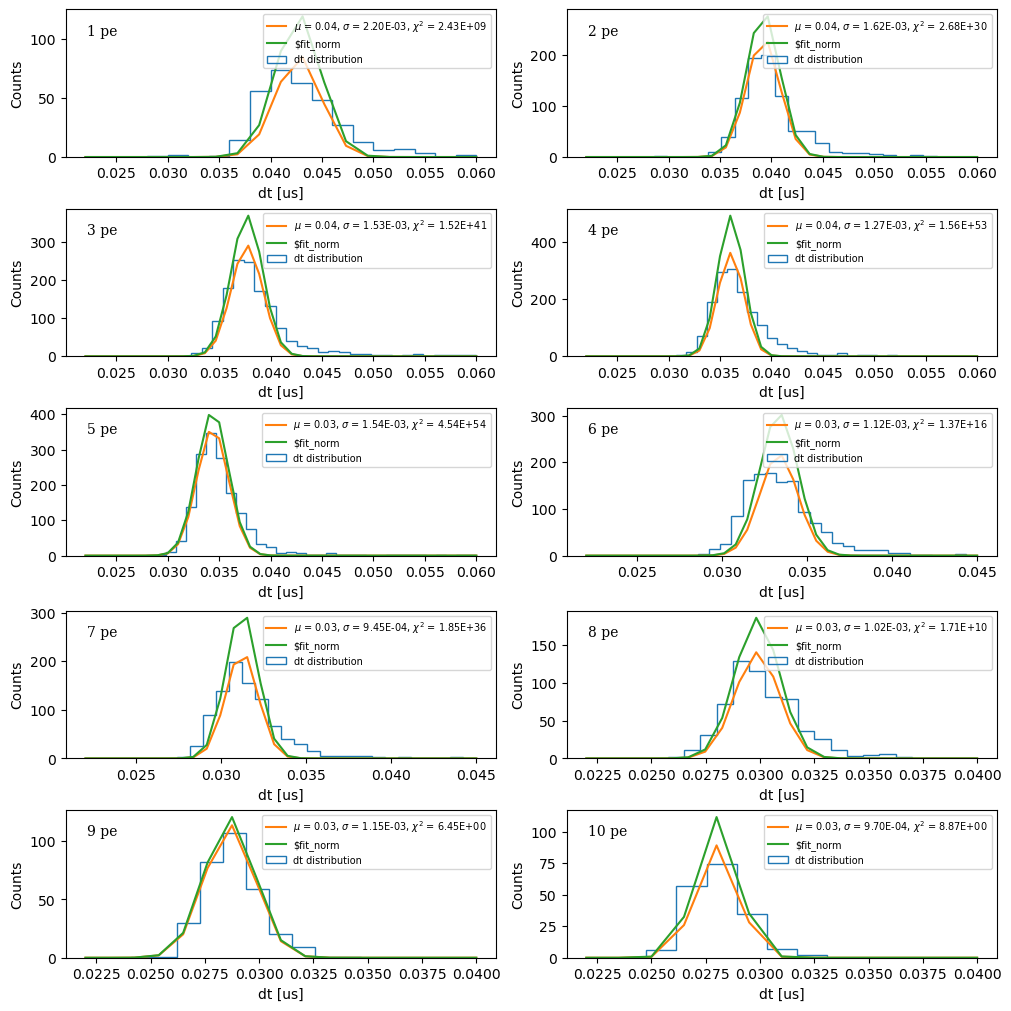

In [110]:
fig, ax = plt.subplots(nrows = math.ceil(n_pe/2.), ncols = 2, figsize=(10,10), constrained_layout=True)

n_row = 0

t_res = np.zeros(n_pe)
t_res_err = np.zeros(n_pe)

for pe in range(n_pe):
# for pe in range(8, 9):
    
    n_col = pe%2
    
    N_ev = len(dt[mask_pe[pe]])
    n_bins = int(np.sqrt(N_ev))
#     n_bins = 10*int(np.sqrt(N_ev))
#     n_bins = 100
    
    region_min = 0.022
    region_max = .06
    if (pe + 1 >= 6):
        region_max = 0.045
    if (pe + 1 > 7):
        region_max = 0.04
    
    events, bins, bars = ax[n_row, n_col].hist(dt[mask_pe[pe]], n_bins, 
                                               density=False,
                                               range=(region_min, region_max),
                                               label='dt distribution', 
                                               histtype='step')
    
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)
    y_err = np.sqrt(events)
    
    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(y_err > 0., y_err, 1e-3),
#                                           p0=[1, (bins[:-1])[events > 0].mean(), 0.001]) 
                                          p0=[events.sum(), (bins[:-1])[events > 0].mean(), 0.001]) 
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
#                                           bounds=([1,  0.9*bins.mean(), 1e-4], [3., bins.mean(), 1e-2])) 


#     best_fit_line = gauss(x_ax, *popt)
    best_fit_line = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum()
    a, mu, sigma = popt
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
    # Calculate p-value and chi-square
    fit_norm = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum() # need to normalize the fit 
    chi2, p_value = stats.chisquare(f_obs = events, f_exp = fit_norm, axis = None)
    chi2 = chi2/events.sum()
#     chi2, p_value = stats.chisquare(f_obs = events, f_exp = gauss(x_ax, *popt))    
    
#     residuals = events - gauss(x_ax, *popt)
#     data_err = np.sqrt(events)
    
#     chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
    
#     print(chi2, stats.)
    
    t_res[pe] = sigma
    t_res_err[pe] = sigma_err

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2E'%(mu, sigma, chi2))
    ax[n_row, n_col].plot(x_ax, fit_norm, '-', 
                          label='fit_norm')
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')

    ax[n_row, n_col].legend(fontsize=7, loc='upper right')
    
    n_row += pe%2
    

/tmp/ipykernel_80632/3456729253.py:59: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_80632/3456729253.py:59: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_80632/3456729253.py:59: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_80632/3456729253.py:59: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_80632/3456729253.py:59: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_80632/3456729253.py:59: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residu

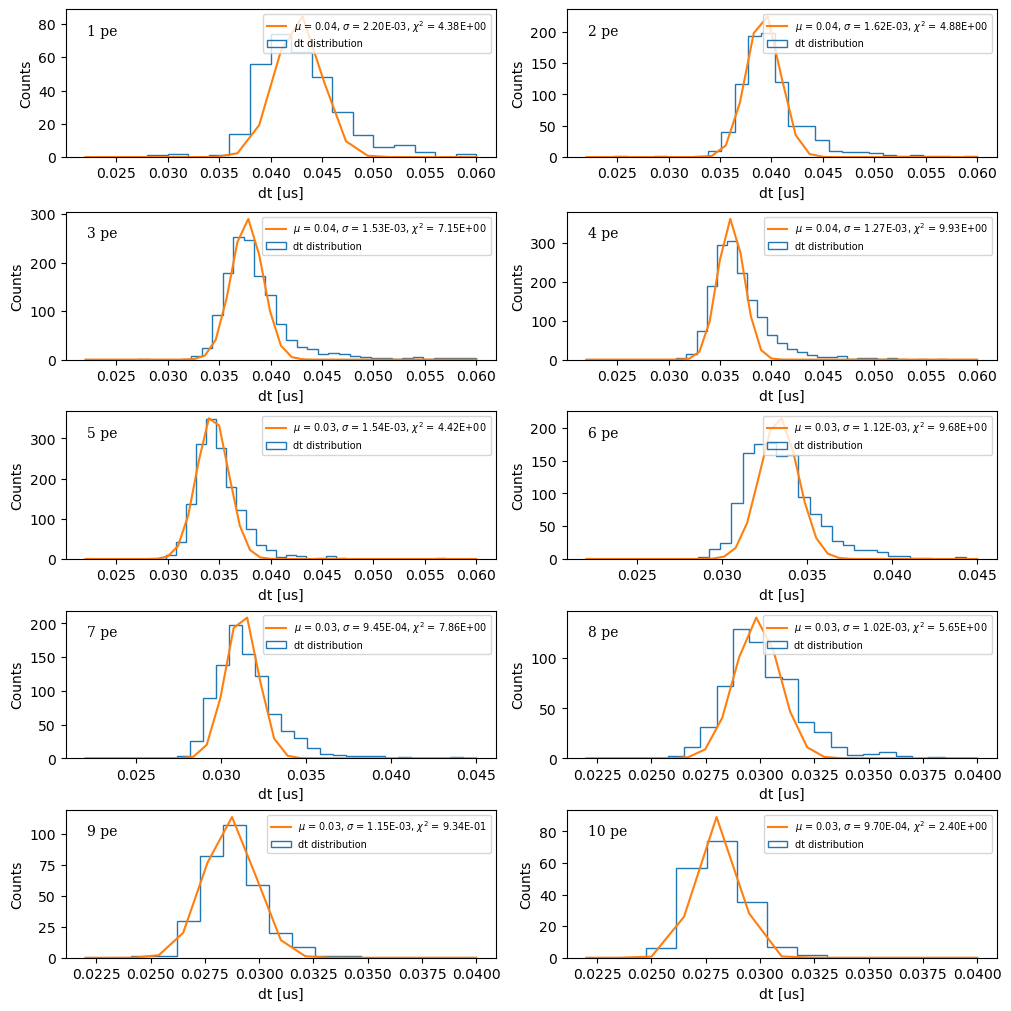

In [111]:
fig, ax = plt.subplots(nrows = math.ceil(n_pe/2.), ncols = 2, figsize=(10,10), constrained_layout=True)

n_row = 0

t_res = np.zeros(n_pe)
t_res_err = np.zeros(n_pe)

for pe in range(n_pe):
# for pe in range(8, 9):
    
    n_col = pe%2
    
    N_ev = len(dt[mask_pe[pe]])
    n_bins = int(np.sqrt(N_ev))
#     n_bins = 10*int(np.sqrt(N_ev))
#     n_bins = 100
    
    region_min = 0.022
    region_max = .06
    if (pe + 1 >= 6):
        region_max = 0.045
    if (pe + 1 > 7):
        region_max = 0.04
    
    events, bins, bars = ax[n_row, n_col].hist(dt[mask_pe[pe]], n_bins, 
                                               density=False,
                                               range=(region_min, region_max),
                                               label='dt distribution', 
                                               histtype='step')
    
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)
    y_err = np.sqrt(events)
    
    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(y_err > 0., y_err, 1e-3),
#                                           p0=[1, (bins[:-1])[events > 0].mean(), 0.001]) 
                                          p0=[events.sum(), (bins[:-1])[events > 0].mean(), 0.001]) 
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
#                                           bounds=([1,  0.9*bins.mean(), 1e-4], [3., bins.mean(), 1e-2])) 


#     best_fit_line = gauss(x_ax, *popt)
    best_fit_line = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum()
    a, mu, sigma = popt
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
    # Calculate p-value and chi-square
#     fit_norm = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum() # need to normalize the fit 
#     chi2, p_value = stats.chisquare(f_obs = events, f_exp = fit_norm, axis = None)
#     chi2 = chi2/events.sum()
#     chi2, p_value = stats.chisquare(f_obs = events, f_exp = gauss(x_ax, *popt))    
    
    residuals = events - gauss(x_ax, *popt)
    data_err = np.sqrt(events)
    
    chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
    chi2 /= len(bins)
    
    t_res[pe] = sigma
    t_res_err[pe] = sigma_err

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2E'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')

    ax[n_row, n_col].legend(fontsize=7, loc='upper right')
    
    n_row += pe%2
    

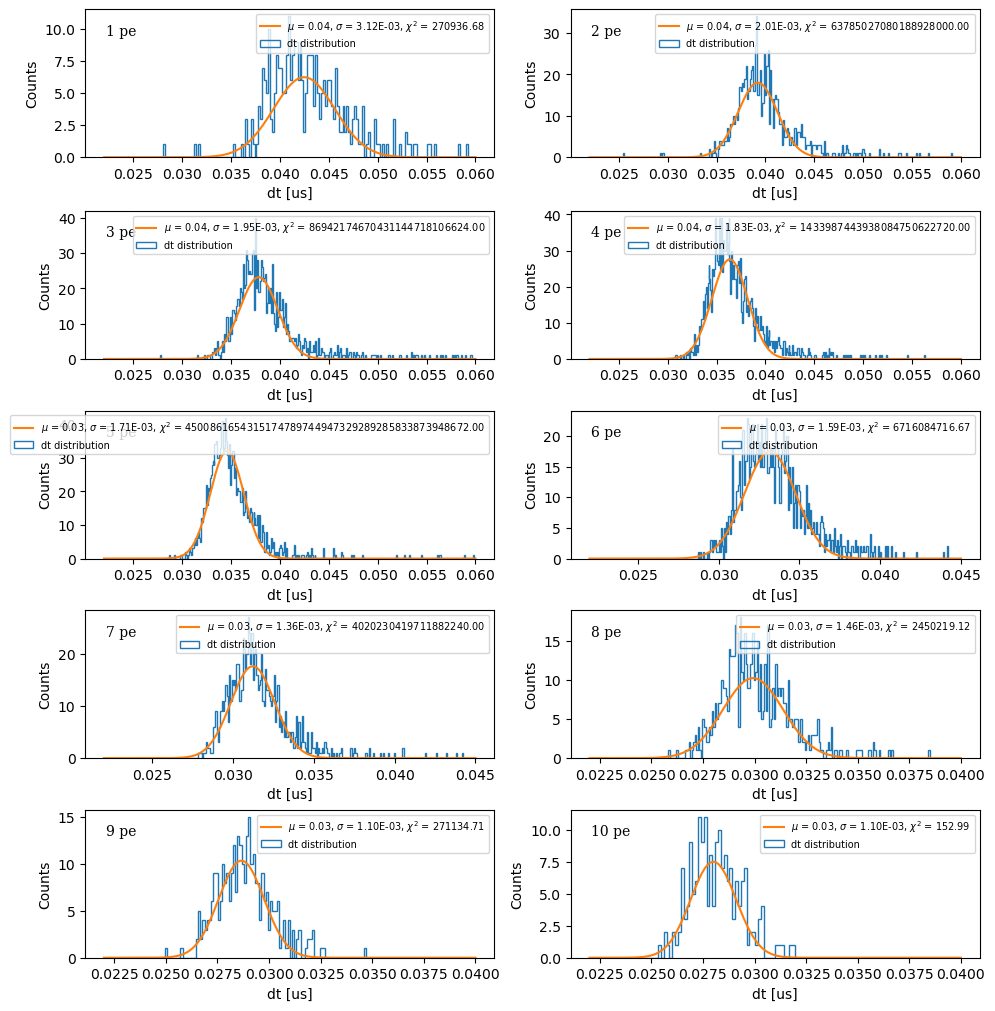

In [120]:
fig, ax = plt.subplots(nrows = math.ceil(n_pe/2.), ncols = 2, figsize=(10,10), constrained_layout=True)

n_row = 0

t_res = np.zeros(n_pe)
t_res_err = np.zeros(n_pe)

for pe in range(n_pe):
# for pe in range(8, 9):
    
    n_col = pe%2
    
    N_ev = len(dt[mask_pe[pe]])
    n_bins = int(np.sqrt(N_ev))
    n_bins = 10*int(np.sqrt(N_ev))
#     n_bins = 100
    
    region_min = 0.022
    region_max = .06
    if (pe + 1 >= 6):
        region_max = 0.045
    if (pe + 1 > 7):
        region_max = 0.04
    
    events, bins, bars = ax[n_row, n_col].hist(dt[mask_pe[pe]], n_bins, 
                                               density=False,
                                               range=(region_min, region_max),
                                               label='dt distribution', 
                                               histtype='step')
    
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)
    y_err = np.where(events > 0., np.sqrt(events), 1.)
    
    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
#                                           sigma = np.where(y_err > 0., y_err, 1e-3),
                                          sigma = y_err,
#                                           p0=[1, (bins[:-1])[events > 0].mean(), 0.001]) 
                                          p0=[events.sum(), (bins[:-1])[events > 0].mean(), 0.001]) 
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
#                                           bounds=([1,  0.9*bins.mean(), 1e-4], [3., bins.mean(), 1e-2])) 


#     best_fit_line = gauss(x_ax, *popt)
    best_fit_line = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum()
    a, mu, sigma = popt
    
#     print(events.sum(), best_fit_line.sum())
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
    # Calculate p-value and chi-square
    fit_norm = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum() # need to normalize the fit 
    chi2, p_value = stats.chisquare(f_obs = events, f_exp = fit_norm, axis = None)
#     print(chi2)
#     chi2 = chi2/events.sum()
#     print(chi2)
#     chi2, p_value = stats.chisquare(f_obs = events, f_exp = gauss(x_ax, *popt))    
    
#     residuals = events - gauss(x_ax, *popt)
#     data_err = np.sqrt(events)
    
#     chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
    
#     print(chi2, stats.)
    
    t_res[pe] = sigma
    t_res_err[pe] = sigma_err

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2f'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')

    ax[n_row, n_col].legend(fontsize=7, loc='upper right')
    
    n_row += pe%2
    

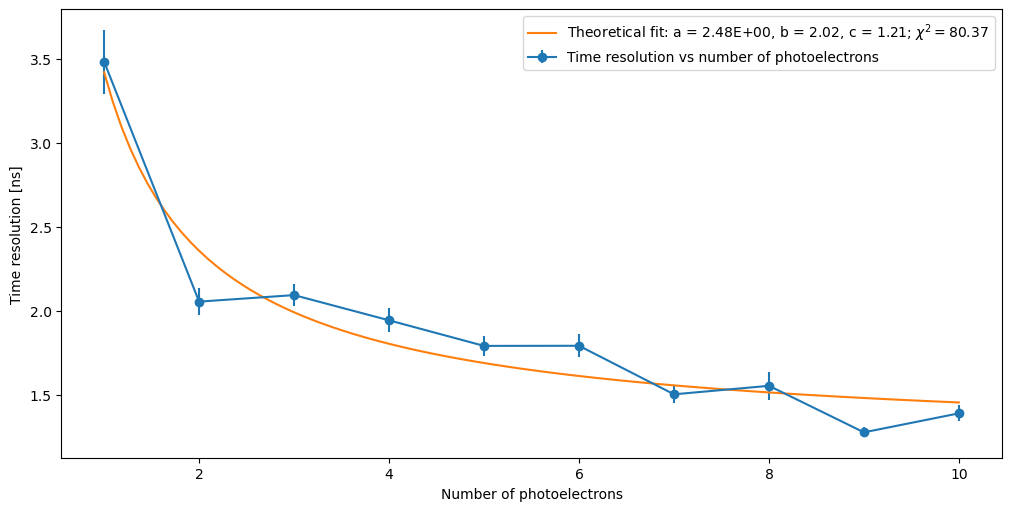

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

x_ax = np.arange(len(t_res)) + 1

ax.errorbar(x_ax, t_res*1e3, yerr = t_res_err*1e3, fmt = '-o', label = 'Time resolution vs number of photoelectrons')

ax.set_ylabel('Time resolution [ns]')
ax.set_xlabel('Number of photoelectrons')


# Resolution fit
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
popt, pcov = scipy.optimize.curve_fit(resolution_eq, x_ax, t_res*1e3, 
                                      bounds=([0., 0., 0.], [np.inf, np.inf, np.inf])) 

aa, bb, cc = popt


# Calculate the residuals and chi-square
residuals = t_res*1e3 - resolution_eq(x_ax, *popt)
data_err = t_res_err*1e3

chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


x_ax_fit = np.linspace(x_ax.min(), x_ax.max(), 100)
best_fit_line = resolution_eq(x_ax_fit, aa, bb, cc)

ax.plot(x_ax_fit, best_fit_line, '-', 
        label='Theoretical fit: a = %.2E, b = %.2f, c = %.2f; $\chi^{2} = %.2f$'%(aa, bb, cc, chi2))

ax.legend(loc = 'best')

<p style="font-size: 17px; color: black;"> Energy resolution calculation

0.4305949008498583 0.43059490084985846 0.43059490084985835
0.487394957983193 0.48739495798319304 0.48739495798319304
0.6218487394957982 0.6218487394957986 0.6218487394957983
0.6540880503144653 0.6540880503144655 0.6540880503144654
0.654088050314466 0.6540880503144663 0.6540880503144662
0.5845511482254696 0.5845511482254698 0.5845511482254697
0.5031446540880508 0.5031446540880509 0.5031446540880509
0.40336134453781475 0.4033613445378148 0.4033613445378148
0.28936170212765944 0.2893617021276595 0.2893617021276595
0.2184873949579831 0.21848739495798314 0.21848739495798314


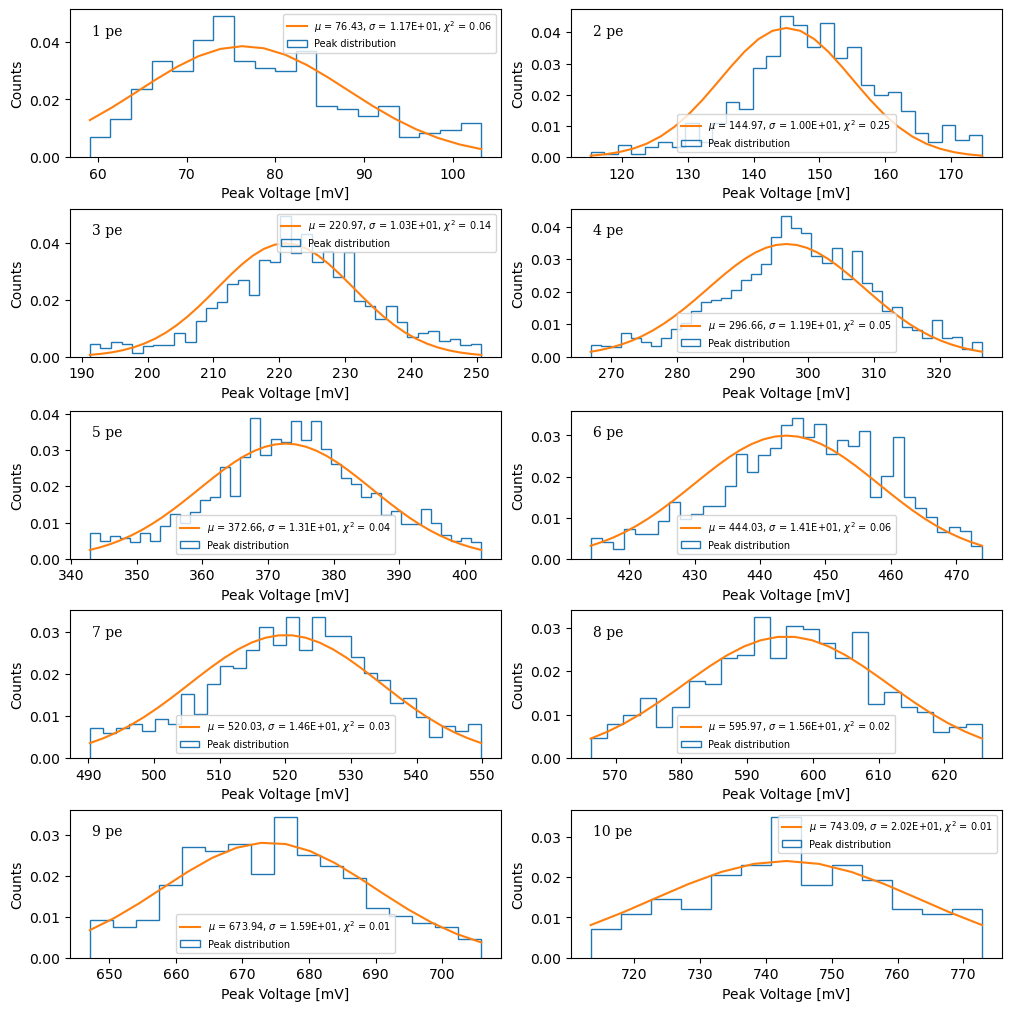

In [123]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(10,10), constrained_layout=True)

n_row = 0

e_res = np.zeros(n_pe)
e_res_err = np.zeros(n_pe)

for pe in range(n_pe):
    
    n_col = pe%2
    
    N_ev = len(s_peak[mask_pe[pe]])
#     n_bins = 5*int(np.sqrt(N_ev))
    n_bins = int(np.sqrt(N_ev))
    
    events, bins, bars = ax[n_row, n_col].hist(s_peak[mask_pe[pe]], n_bins, 
                                     density=True, 
#                                                range=(0.08, 0.15),
                                     label='Peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

#     # gaussian fit
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, sigma = np.sqrt(events),
#                                           bounds=([1.,  0.9*bins.mean(), 10.], [np.inf, bins.mean(), 60.])) 
                                          bounds=([events.sum(),  0.9*bins.mean(), 10.], [np.inf, bins.mean(), 60.])) 
#                                           bounds=([1.,  0.9*bins.mean(), 10.], 
#                                                   [events.sum() + 10, bins.mean(), 60.])) 
    
    best_fit_line = gauss(x_ax, *popt)
    a, mu, sigma = popt
    
    print(events.sum(), best_fit_line.sum(), a)
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
#     # Calculate the residuals and chi-square
#     residuals = events - gauss(x_ax, *popt)
#     data_err = np.sqrt(events)
    
#     chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))
    
    # Calculate p-value and chi-square
    fit_norm = best_fit_line*events.sum()/best_fit_line.sum() # need to normalize the fit 
#     chi2, p_value = stats.chisquare(f_obs = events, f_exp = fit_norm, axis = None)
    chi2, p_value = stats.chisquare(f_obs = events, f_exp = best_fit_line, axis = None)
    
    e_res[pe] = 100*sigma/mu
    e_res_err[pe] = 100*np.sqrt( (sigma_err/mu)**2 + (sigma*mu_err/mu**2)**2 )

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, best_fit_line, '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2f'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('Peak Voltage [mV]')

    ax[n_row, n_col].legend(fontsize=7, loc='best')
    
    n_row += pe%2
    

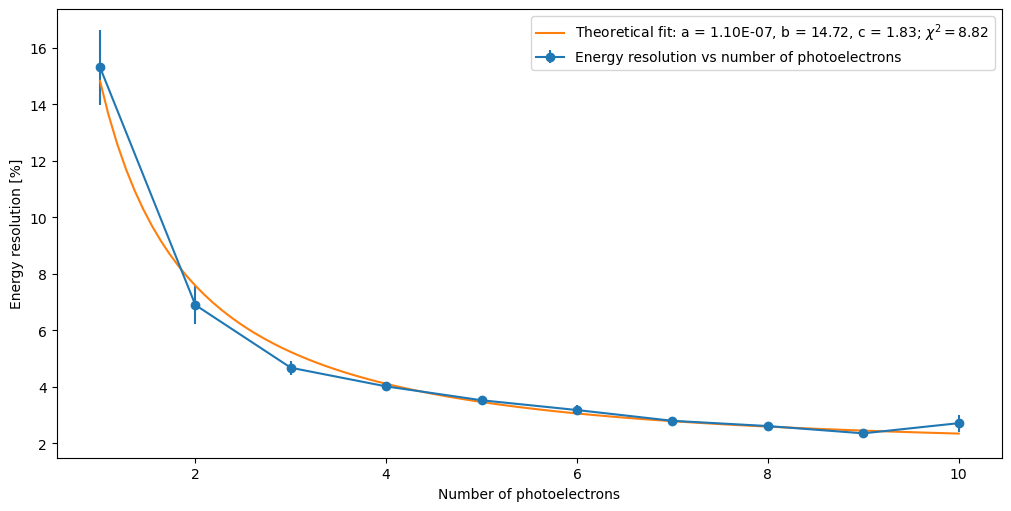

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

x_ax = np.arange(len(e_res)) + 1


ax.errorbar(x_ax, e_res, yerr = e_res_err, fmt = '-o', label = 'Energy resolution vs number of photoelectrons')

ax.set_ylabel('Energy resolution [%]')
ax.set_xlabel('Number of photoelectrons')



# Resolution fit
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
popt, pcov = scipy.optimize.curve_fit(resolution_eq, x_ax, e_res, 
                                      bounds=([0., 0., 0.], [np.inf, np.inf, np.inf])) 

aa, bb, cc = popt


# Calculate the residuals and chi-square
residuals = e_res - resolution_eq(x_ax, *popt)
data_err = e_res_err

chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


x_ax_fit = np.linspace(x_ax.min(), x_ax.max(), 100)
best_fit_line = resolution_eq(x_ax_fit, aa, bb, cc)

ax.plot(x_ax_fit, best_fit_line, '-', 
        label='Theoretical fit: a = %.2E, b = %.2f, c = %.2f; $\chi^{2} = %.2f$'%(aa, bb, cc, chi2))

    
ax.legend(loc = 'best')